# Machine Learning Engineer Nanodegree: Forecasting COVID-19 Cases – A `Time Series Forecasting` Model

### Domain Background
On December 31, 2019, the World Health Organization (WHO) was informed of an outbreak of “pneumonia of unknown cause” detected in Wuhan City, Hubei Province, China. Identified as coronavirus disease 2019, it quickly came to be known as COVID-19 and has resulted in an ongoing global pandemic. As of 20 June 2020, more than 8.74 million cases have been reported across 188 countries and territories, resulting in more than 462,000 deaths. More
than 4.31 million people have recovered.[^1]

In response to this ongoing public health emergency, Johns Hopkins University (JHU), a private research university in Maryland, USA, developed an interactive web-based dashboard hosted by their Center for Systems Science and Engineering (CSSE). The dashboard visualizes and tracks reported cases in real-time, illustrating the location and number of confirmed COVID-19 cases, deaths and recoveries for all affected countries. It is used by researchers, public health authorities, news
agencies and the general public. All the data collected and displayed is made freely available in a [GitHub repository](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data).

### Problem Statement
This project seeks to forecast number of people infected and number of deaths caused by COVID-19 for a time duration of 14-days based on
historical data from JHU. I will be using Amazon SageMaker DeepAR forecasting algorithm, a supervised learning algorithm for forecasting
scalar (one-dimensional) time series using recurrent neural networks (RNN) to produce both point and probabilistic forecasts[^2].
DeepAR is an underutilized approach in this area.[^3] The dataset contains hundreds of related time series, and DeepAR outperforms classical
forecasting methods including but not limited to autoregressive integrated moving average (ARIMA), exponential smoothing (ETS), Time Series
Forecasting with Linear Learner for this type of applications. I will be using [DeepAR](https://github.com/sahussain/ML_SageMaker_Studies/blob/master/Time_Series_Forecasting/Energy_Consumption_Solution.ipynb) and [Time Series Forecasting with Linear Learner](https://github.com/awslabs/amazon-sagemaker-examples/blob/80333fd4632cf6d924d0b91c33bf80da3bdcf926/introduction_to_applying_machine_learning/linear_time_series_forecast/linear_time_series_forecast.ipynb)

-----------
[^1]:[COVID-19 Dashboard](https://systems.jhu.edu/research/public-health/ncov/) by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (JHU)". ArcGIS. Johns Hopkins University. Retrieved 20 June 2020.

[^2]:[DeepAR Forecasting Algorithm. Amazon Web Services](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html). Retrieved 20 June, 2020 

[^3]:[Time series prediction](https://www.telesens.co/2019/06/08/time-series-prediction/). Telesens. Retrieved 20 June, 2020.

-----------

## Initialization

### Loading in the resources.

In [1]:
#only need to run this once
!pip install -r requirements.txt

    100% |████████████████████████████████| 17.3MB 2.5MB/s eta 0:00:01
    100% |████████████████████████████████| 10.5MB 5.6MB/s eta 0:00:01
    100% |████████████████████████████████| 112kB 39.0MB/s ta 0:00:01
    100% |████████████████████████████████| 13.1MB 4.2MB/s eta 0:00:01
    100% |████████████████████████████████| 8.1MB 7.9MB/s eta 0:00:01
    100% |████████████████████████████████| 7.0MB 9.2MB/s eta 0:00:01
    100% |████████████████████████████████| 92.6MB 441kB/s eta 0:00:01
    100% |████████████████████████████████| 1.5MB 22.7MB/s ta 0:00:01
    100% |████████████████████████████████| 727kB 31.7MB/s ta 0:00:01
    100% |████████████████████████████████| 307kB 35.0MB/s ta 0:00:01
    100% |████████████████████████████████| 368kB 35.3MB/s ta 0:00:01
    100% |████████████████████████████████| 19.7MB 2.5MB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 24.3MB/s ta 0:00:01
    100% |████████████████████████████████| 3.2MB 11.0MB/s ta 0:00:01
    100% |██████

In [2]:
import warnings
warnings.filterwarnings("ignore")
from ts_utils import *

In [3]:
from urllib.request import urlretrieve
import os # os for saving
import io
import sys
import time
import random
SEED_VALUE=10
import statsmodels.tsa.stattools as sts

### Download function

In [4]:
def progress_report_hook(count, block_size, total_size):
    mb = int(count * block_size // 1e6)
    if count % 50 == 0:
        sys.stdout.write("\r{} MB downloaded".format(mb))
        sys.stdout.flush()

def download(DATA_HOST, DATA_PATH, FILE_NAME, OVERRIDE=1, reporthook=progress_report_hook):
    if OVERRIDE:
        print("downloading dataset, can take a few minutes depending on your connection")
        urlretrieve(DATA_HOST + DATA_PATH + FILE_NAME, FILE_NAME, reporthook=progress_report_hook)
    else:
        print("File found skipping download")

### Clean-up functions

In [5]:
#convenience function to delete prediction endpoints after we're done with them form udacity
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))

-----------

## Load and Explore the Data

### Downloading data

In [6]:
DATA_HOST = "https://raw.githubusercontent.com"
DATA_PATH = "/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
FILE_NAME = "time_series_covid19_confirmed_US.csv"

In [7]:
download(DATA_HOST, DATA_PATH, FILE_NAME,0)

File found skipping download


### Loading data into pandas

In [8]:
csv_file = 'time_series_covid19_confirmed_US.csv'
covid_df = pd.read_csv(csv_file)

### Examining the Data

In [9]:
covid_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,183,183,185,186,188,192,200,222,222,222
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,30,30,30,30,30,30,30,30,30,30
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,5690,5811,5890,5951,6003,6111,6195,6463,6525,6564
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,72,72,72,72,73,73,73,73,76,76




## Datasets and Inputs
The datasets are accessed from files provided by the JHU GitHub
repository [time_series_covid19_confirmed_US.csv](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv)

The file have the same columns:
* UID - UID = 840 (country code3) + 000XX (state FIPS code). Ranging from
8400001 to 84000056.
* iso2- Officially assigned country code identifiers 2 Chr (US, CA, ...)
* iso3 - Officially assigned country code identifiers 3 Chr.(USA, CAN,
...)
* code3- country code USA = 840
* FIPS -Federal Information Processing Standards code that uniquely
identifies counties within the USA.
* admin2 - County name. US only.
* Province_State - The name of the State within the USA.
* Country_Region - The name of the Country (US).
* Combined_Key - Province_State + Country_Region
* Population - Population
* Number of cases are is columns where each column is a day



In [10]:
#Geting colunm names
list(covid_df.columns)

['UID',
 'iso2',
 'iso3',
 'code3',
 'FIPS',
 'Admin2',
 'Province_State',
 'Country_Region',
 'Lat',
 'Long_',
 'Combined_Key',
 '1/22/20',
 '1/23/20',
 '1/24/20',
 '1/25/20',
 '1/26/20',
 '1/27/20',
 '1/28/20',
 '1/29/20',
 '1/30/20',
 '1/31/20',
 '2/1/20',
 '2/2/20',
 '2/3/20',
 '2/4/20',
 '2/5/20',
 '2/6/20',
 '2/7/20',
 '2/8/20',
 '2/9/20',
 '2/10/20',
 '2/11/20',
 '2/12/20',
 '2/13/20',
 '2/14/20',
 '2/15/20',
 '2/16/20',
 '2/17/20',
 '2/18/20',
 '2/19/20',
 '2/20/20',
 '2/21/20',
 '2/22/20',
 '2/23/20',
 '2/24/20',
 '2/25/20',
 '2/26/20',
 '2/27/20',
 '2/28/20',
 '2/29/20',
 '3/1/20',
 '3/2/20',
 '3/3/20',
 '3/4/20',
 '3/5/20',
 '3/6/20',
 '3/7/20',
 '3/8/20',
 '3/9/20',
 '3/10/20',
 '3/11/20',
 '3/12/20',
 '3/13/20',
 '3/14/20',
 '3/15/20',
 '3/16/20',
 '3/17/20',
 '3/18/20',
 '3/19/20',
 '3/20/20',
 '3/21/20',
 '3/22/20',
 '3/23/20',
 '3/24/20',
 '3/25/20',
 '3/26/20',
 '3/27/20',
 '3/28/20',
 '3/29/20',
 '3/30/20',
 '3/31/20',
 '4/1/20',
 '4/2/20',
 '4/3/20',
 '4/4/20',
 '4/5

In [11]:
#Group by state, getting red of unnecessary columns
covid_df = covid_df.drop(['UID','iso2','iso3','code3','FIPS','Admin2','Country_Region','Lat','Long_','Combined_Key'], axis=1).groupby("Province_State").sum().T

In [12]:
covid_df.head()

Province_State,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Diamond Princess,...,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
1/22/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1/23/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1/24/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1/25/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1/26/20,0,0,0,1,0,2,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [13]:
#Getting State list
state = list(covid_df.columns)

In [14]:
print(state)

['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Diamond Princess', 'District of Columbia', 'Florida', 'Georgia', 'Grand Princess', 'Guam', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Northern Mariana Islands', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virgin Islands', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']


In [15]:
print(len(state))

58


In [16]:
## convert index to datetime
covid_df.index = pd.to_datetime(covid_df.index, infer_datetime_format=True)

In [17]:
covid_df.head()

Province_State,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Diamond Princess,...,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2020-01-26,0,0,0,1,0,2,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [18]:
covid_df.describe()

Province_State,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Diamond Princess,...,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
count,153.000000,153.000000,153.0,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,...,153.00000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000
mean,6704.627451,226.888889,0.0,8508.895425,2991.496732,43050.862745,10306.313725,16891.450980,3412.379085,31.346405,...,9049.03268,25208.424837,3971.790850,496.921569,35.228758,15125.764706,9713.464052,776.098039,6509.254902,366.568627
std,8637.161197,228.482049,0.0,12390.160996,4085.802010,53191.222424,11204.514843,18206.565912,4023.401688,23.561878,...,10743.99214,31665.379917,4917.486198,456.895294,31.229098,19562.752722,9507.069714,858.828354,8056.979499,397.825004
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.0,1.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000
50%,2169.000000,213.000000,0.0,2575.000000,946.000000,17351.000000,5429.000000,7781.000000,928.000000,49.000000,...,4139.00000,8925.000000,1739.000000,575.000000,43.000000,3335.000000,8692.000000,412.000000,2578.000000,216.000000
75%,11373.000000,388.000000,0.0,13169.000000,4463.000000,76693.000000,21232.000000,36085.000000,7373.000000,49.000000,...,16960.00000,45721.000000,6913.000000,933.000000,69.000000,28672.000000,17951.000000,1447.000000,11685.000000,716.000000
max,30454.000000,758.000000,0.0,54599.000000,16083.000000,184765.000000,30689.000000,45782.000000,10820.000000,49.000000,...,35553.00000,117790.000000,17906.000000,1163.000000,76.000000,58465.000000,28870.000000,2552.000000,25068.000000,1230.000000


In [19]:
## create total cases and new cases

def getCases(df, aState):
    # create total cases column
    error = 0
    try:
        df = pd.DataFrame(index=df.index, data=df[aState].values, columns=["total"])
        #print(dtf.head())
        # create daily changes column
        df["new"] = df["total"] - df["total"].shift(1)
        # Handling Missing Values
        df["new"] = df["new"].fillna(method='bfill')
    except:
        print("No State " + aState + " found")
        error = 1
        df = pd.DataFrame() 
    return [df, error]

### Get New York

In [20]:
covid_df_NY = getCases(covid_df, 'NewYork')[0]

No State NewYork found


In [21]:
covid_df_NY = getCases(covid_df, 'New York')[0]

In [22]:
print(covid_df_NY.shape)

(153, 2)


In [23]:
covid_df_NY.describe()

,total,new
count,153.000000,153.000000
mean,168552.398693,2539.137255
std,162319.641582,3209.162717
min,0.000000,0.000000
25%,0.000000,0.000000
50%,139875.000000,1075.000000
75%,345813.000000,4073.000000
max,388488.000000,11434.000000


## Plotting the Data

In [24]:
def getColourList(nColours):
    Colours = []
    for i in range(nColours):
        Colours.append('#%06X' % random.randint(0, 0xFFFFFF))
    return Colours

def PlotState(df, aState):
    Cases=getCases(df, aState)
    error = Cases[1]
    if not error:
        Cases_city= Cases[0]
        plt.figure(figsize=(15,8))
        plt.title("COVID-19 Cases For: " + aState)
        Cases_city.total.plot(label='Total', linewidth=3, color='red')
        Cases_city.new.plot(label='New', linewidth=3, color='green')
        plt.legend()
        plt.show()
    else:
        print("No State by " + aState + " found")

def PlotRandomState(df):
    #random.seed(random.randint(0,20))
    rState = random.randint(0, len(state))   
    Cases=getCases(df, state[rState])
    error = Cases[1]
    
    if not error:
        Cases_city= Cases[0]
        plt.figure(figsize=(15,8))
        plt.title("COVID-19 Cases For: " + state[rState])
        Cases_city.total.plot(label='Total', linewidth=3, color='red')
        Cases_city.new.plot(label='New', linewidth=3, color='green')
        plt.legend()
        plt.show()
    else:
        print("No State by " + aState + " found")
    

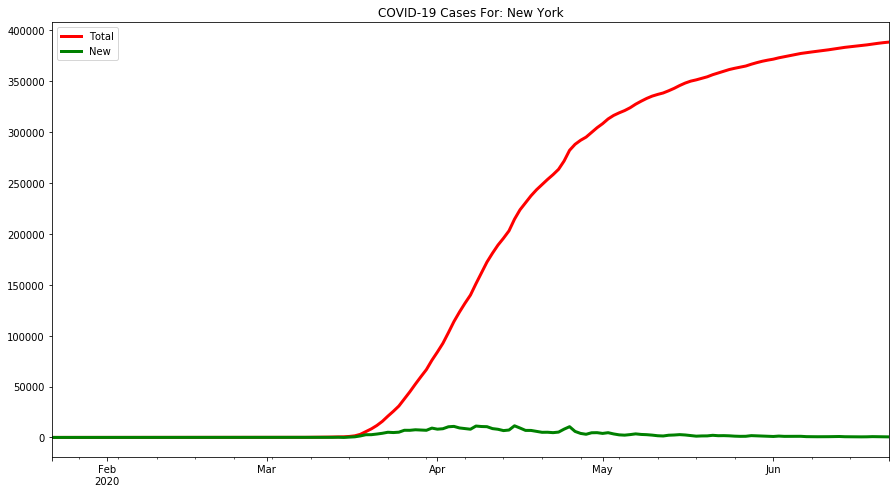

In [25]:
PlotState(covid_df, 'New York')

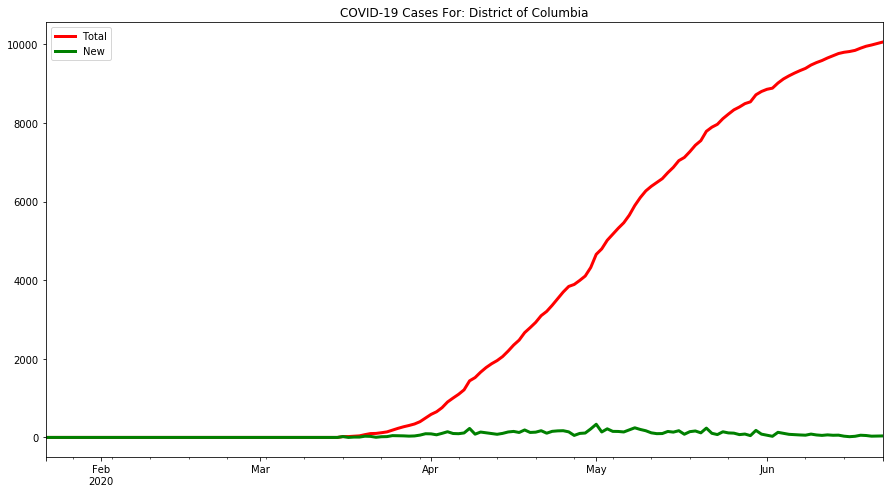

In [27]:
PlotState(covid_df, 'District of Columbia')

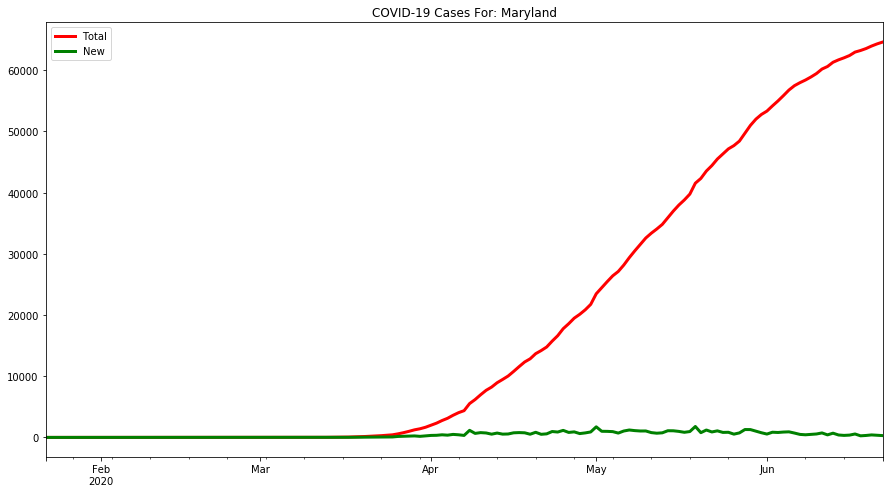

In [28]:
PlotRandomState(covid_df)

-----

## Model Desing & Testing

***fit_curve function***

- parameter
 - param X: array
 - param y: array
 - param f: function to fit (ex. logistic: f(X) = capacity / (1 + np.exp(-k*(X - midpoint)))
                                or gaussian: f(X) = a * np.exp(-0.5 * ((X-mu)/sigma)**2)   )
 - param kind: str - "logistic", "gaussian" or None
 - param p0: array or list of initial parameters (ex. for logistic p0=[np.max(ts), 1, 1])
- return
 - optimal params

`code:`
```Python
def fit_curve(X, y, f=None, kind=None, p0=None):
    ## define f(x) if not specified
    if f is None:
        if kind == "logistic":
            f = lambda p,X: p[0] / (1 + np.exp(-p[1]*(X-p[2])))
        elif find == "gaussian":
            f = lambda p,X: p[0] * np.exp(-0.5 * ((X-p[1])/p[2])**2)
    
    ## find optimal parameters
    model, cov = optimize.curve_fit(f, X, y, maxfev=10000, p0=p0)
    return model
```

***forecast_curve function***

Forecast unknown future.
- parameter
 - param ts: pandas series
 - param f: function
 - param model: list of optim params
 - param pred_ahead: number of observations to forecast (ex. pred_ahead=30)
 - param end: string - date to forecast (ex. end="2016-12-31")
 - param freq: None or str - 'B' business day, 'D' daily, 'W' weekly, 'M' monthly, 'A' annual, 'Q' quarterly
 - param zoom: for plotting
-return df
 - forecast     
 - model
 - ts  
 - residuals
 - conf_int_low
 - conf_int_up
'''

`code:`

```Python
def forecast_curve(ts, f, model, pred_ahead=None, end=None, freq="D", zoom=30, figsize=(15,5)):
    ## fit
    fitted = utils_predict_curve(model, f, X=np.arange(len(ts)))
    dtf = ts.to_frame(name="ts")
    dtf["model"] = fitted
    
    ## index
    index = utils_generate_indexdate(start=ts.index[-1], end=end, n=pred_ahead, freq=freq)
    
    ## forecast
    preds = utils_predict_curve(model, f, X=np.arange(len(ts)+1, len(ts)+1+len(index)))
    dtf = dtf.append(pd.DataFrame(data=preds, index=index, columns=["forecast"]))
    
    ## plot
    utils_plot_parametric(dtf, zoom=zoom)
    return dtf

```

### Defining Epidemic Curve

In [29]:
'''
Function to fit. In this case logistic function:
    f(x) = capacity / (1 + e^-k*(x - midpoint) )
'''
def curve_logistic(X, c, k, m):
    y = c / (1 + np.exp(-k*(X-m)))
    return y

'''
Function to fit. In this case gaussian function:
    f(x) = a * e^(-0.5 * ((x-μ)/σ)**2)
'''
def curve_gaussian(X, a, b, c):
    y = a * np.exp(-0.5 * ((X-b)/c)**2)
    return y

### Total cases

In [30]:
## Fit
model = fit_curve(X=np.arange(len(covid_df_NY["total"])), y=covid_df_NY["total"].values, f=curve_logistic, p0=[np.max(covid_df_NY["total"]), 1, 1])
model

array([ 0.00959215, -0.40674616,  2.15108858])

--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


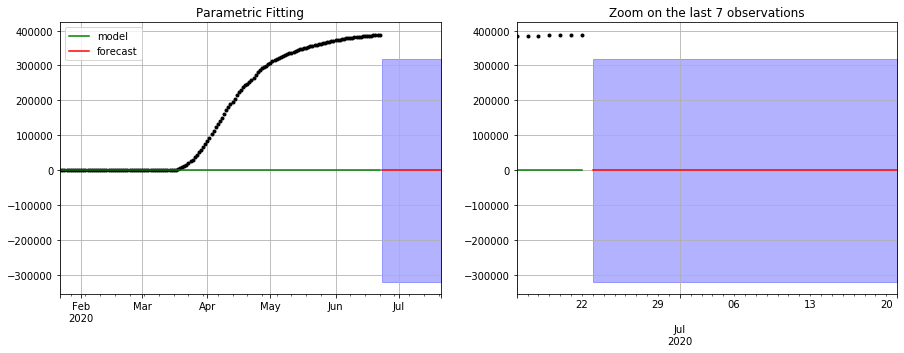

In [31]:
## Forecast
preds = forecast_curve(covid_df_NY["total"], curve_logistic, model, pred_ahead=30, end=None, freq="D", zoom=7, figsize=(15,5))

In [32]:
covid_df_TX = getCases(covid_df, 'Texas')[0]

In [33]:
## Fit
model = fit_curve(X=np.arange(len(covid_df_TX["total"])), y=covid_df_TX["total"].values, f=curve_logistic, p0=[np.max(covid_df_TX["total"]), 1, 1])
model

array([1.64937097e+05, 4.29742126e-02, 1.38528607e+02])

--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


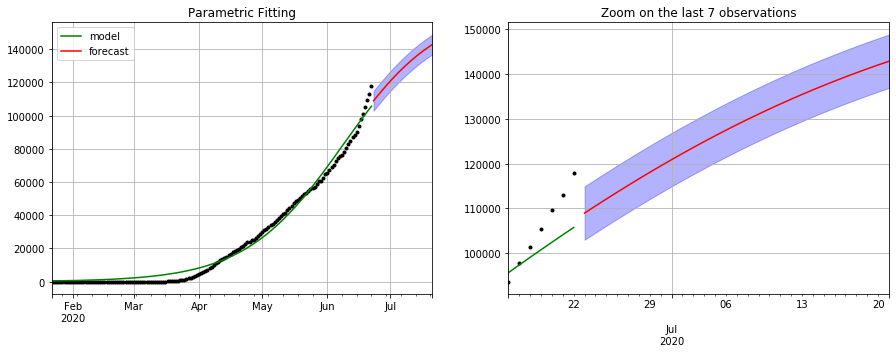

In [34]:
preds = forecast_curve(covid_df_TX["total"], curve_logistic, model, pred_ahead=30, end=None, freq="D", zoom=7, figsize=(15,5))

### New cases

In [40]:
model = fit_curve(X=np.arange(len(covid_df_NY["new"])), y=covid_df_NY["new"].values, f=curve_gaussian, p0=[1, np.mean(covid_df_NY["new"]), np.std(covid_df_NY["new"])])
model

array([9315.47117648,   79.62845125,  -15.34238891])

--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


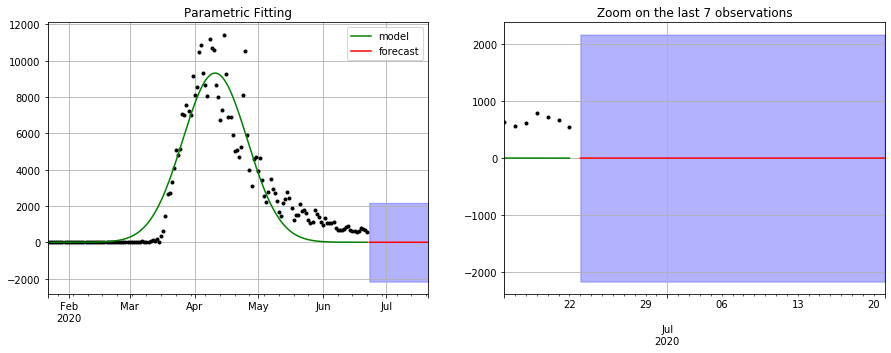

In [41]:
## Forecast
preds = forecast_curve(covid_df_NY["new"], curve_gaussian, model, pred_ahead=30, end=None, freq="D", zoom=7, figsize=(15,5))

In [53]:
def forecast_randomcity_total_cases(df, function=curve_logistic):
    rState = random.randint(0, len(state))   
    Cases=getCases(df, state[rState])[0]
    print('Making model for ' + state[rState])
    model = fit_curve(X=np.arange(len(Cases["total"])), y=Cases["total"].values, f=function, p0=[np.max(Cases["total"]), 1, 1])
    print('forecast ' + state[rState])
    preds = forecast_curve(Cases["total"], function, model, pred_ahead=30, end=None, freq="D", zoom=7, figsize=(15,5))
    
def forecast_randomcity_new_cases(df, function=curve_gaussian):
    rState = random.randint(0, len(state))   
    Cases=getCases(df, state[rState])[0]
    print('Making model for ' + state[rState])
    model = fit_curve(X=np.arange(len(Cases["new"])), y=Cases["new"].values, f=curve_gaussian, p0=[1, np.mean(Cases["new"]), np.std(Cases["new"])])
    print('forecast ' + state[rState])
    preds = forecast_curve(Cases["new"], curve_gaussian, model, pred_ahead=30, end=None, freq="D", zoom=7, figsize=(15,5))
    
def forecast_randomcity_both_cases(df):
    rState = random.randint(0, len(state))   
    Cases=getCases(df, state[rState])[0]
    print("###Total Cases###")
    print('Making model for ' + state[rState])
    model = fit_curve(X=np.arange(len(Cases["total"])), y=Cases["total"].values, f=curve_logistic, p0=[np.max(Cases["total"]), 1, 1])
    print('forecast ' + state[rState])
    preds = forecast_curve(Cases["total"], curve_logistic, model, pred_ahead=30, end=None, freq="D", zoom=7, figsize=(15,5))
    
    print("###New Cases###")
    print('Making model for ' + state[rState])
    model = fit_curve(X=np.arange(len(Cases["new"])), y=Cases["new"].values, f=curve_gaussian, p0=[1, np.mean(Cases["new"]), np.std(Cases["new"])])
    print('forecast ' + state[rState])
    preds = forecast_curve(Cases["new"], curve_gaussian, model, pred_ahead=30, end=None, freq="D", zoom=7, figsize=(15,5))
    
def forecast_aState_both_cases(df, rState):
    #rState = random.randint(0, len(state))   
    Cases=getCases(df, rState)[0]
    print("###Total Cases###")
    print('Making model for ' + rState)
    model = fit_curve(X=np.arange(len(Cases["total"])), y=Cases["total"].values, f=curve_logistic, p0=[np.max(Cases["total"]), 1, 1])
    print('forecast ' + rState)
    preds = forecast_curve(Cases["total"], curve_logistic, model, pred_ahead=30, end=None, freq="D", zoom=7, figsize=(15,5))
    
    print("###New Cases###")
    print('Making model for ' + rState)
    model = fit_curve(X=np.arange(len(Cases["new"])), y=Cases["new"].values, f=curve_gaussian, p0=[1, np.mean(Cases["new"]), np.std(Cases["new"])])
    print('forecast ' + rState)
    preds = forecast_curve(Cases["new"], curve_gaussian, model, pred_ahead=30, end=None, freq="D", zoom=7, figsize=(15,5))
    

Making model for Oklahoma
forecast Oklahoma
--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


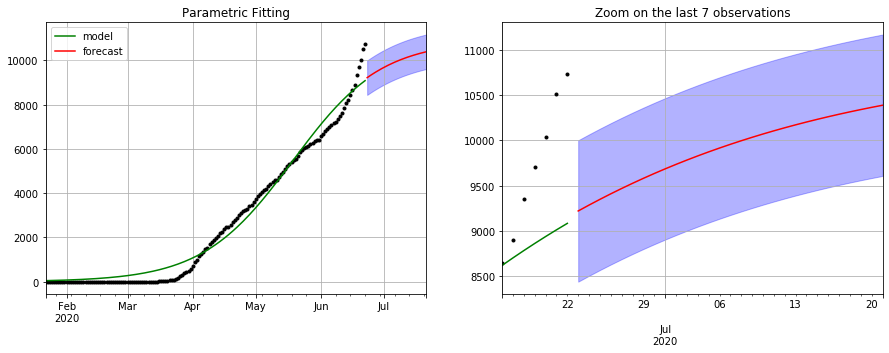

In [54]:
forecast_randomcity_total_cases(covid_df)

###Total Cases###
Making model for Delaware
forecast Delaware
--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


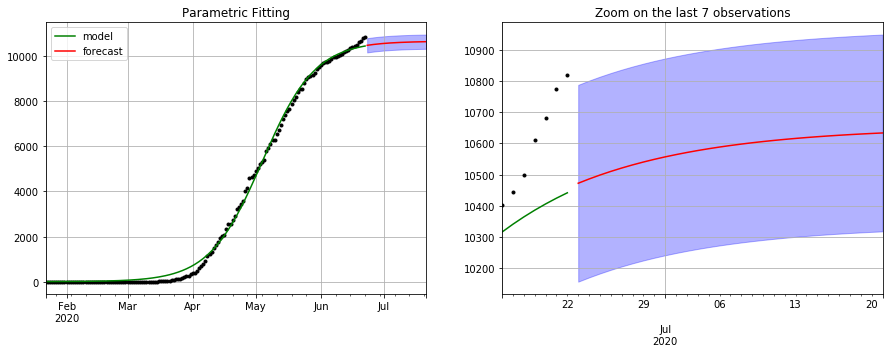

###New Cases###
Making model for Delaware
forecast Delaware
--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


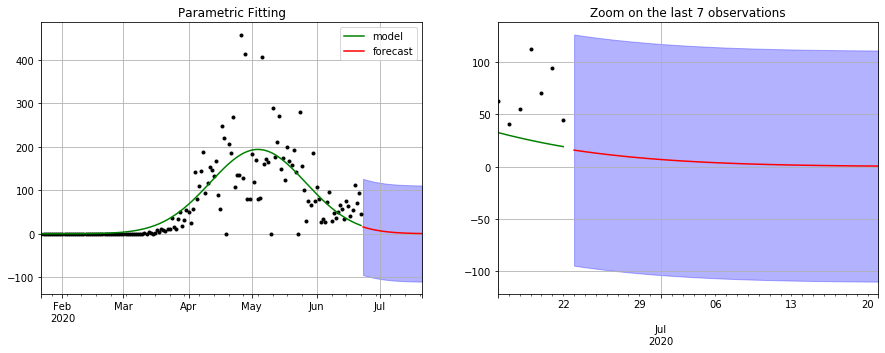

In [55]:
forecast_aState_both_cases(covid_df, "Delaware")

###Total Cases###
Making model for North Dakota
forecast North Dakota
--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


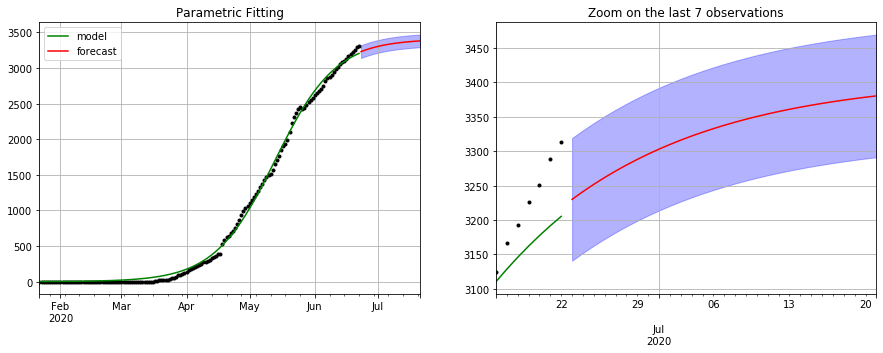

###New Cases###
Making model for North Dakota
forecast North Dakota
--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


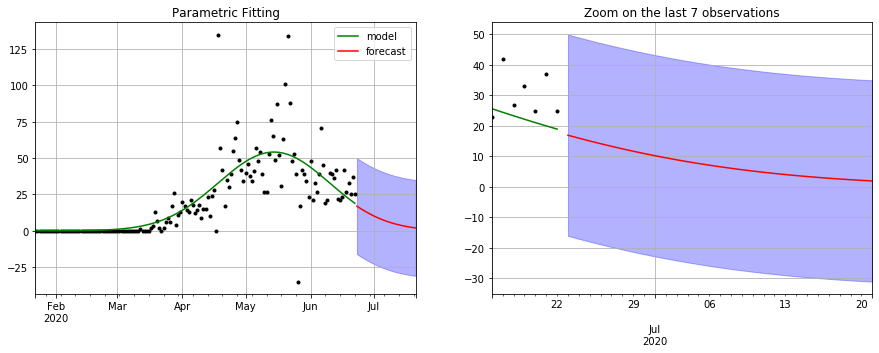

In [56]:
forecast_aState_both_cases(covid_df, "North Dakota")

###Total Cases###
Making model for Maryland
forecast Maryland
--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


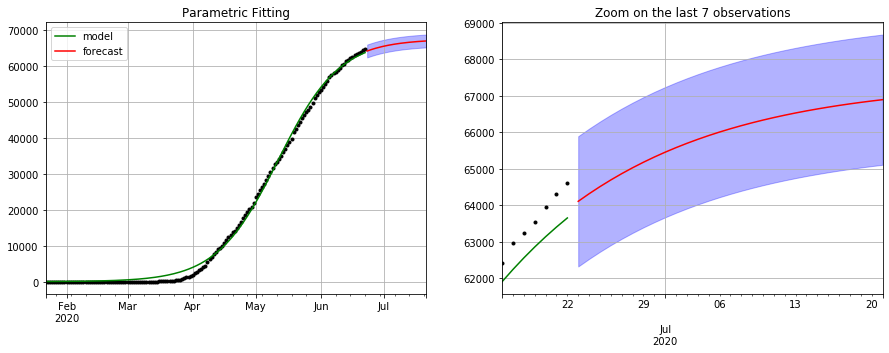

###New Cases###
Making model for Maryland
forecast Maryland
--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


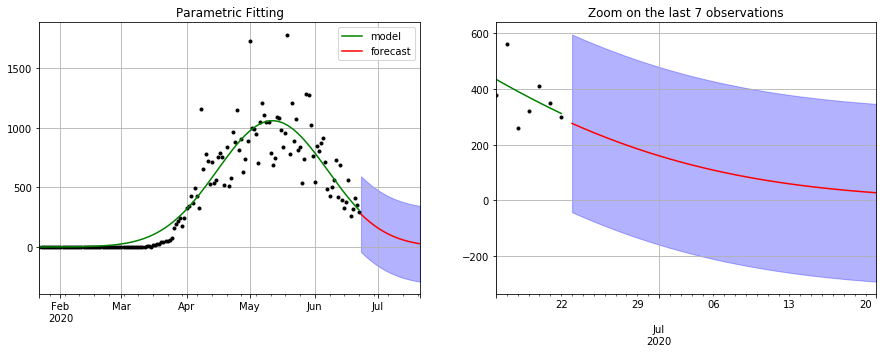

In [57]:
forecast_aState_both_cases(covid_df, "Maryland")

###Total Cases###
Making model for Montana
forecast Montana
--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


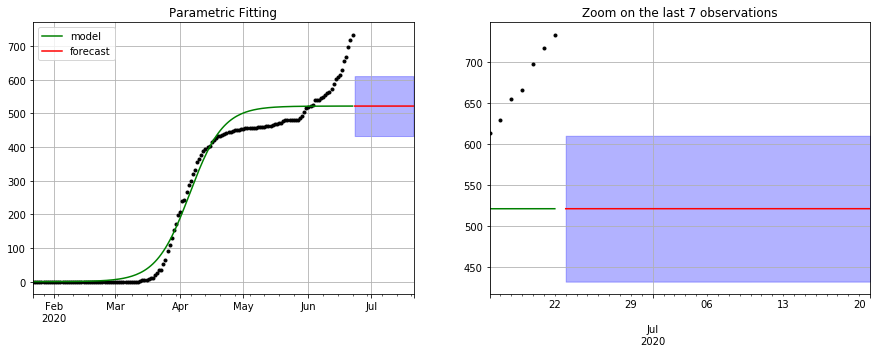

###New Cases###
Making model for Montana
forecast Montana
--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


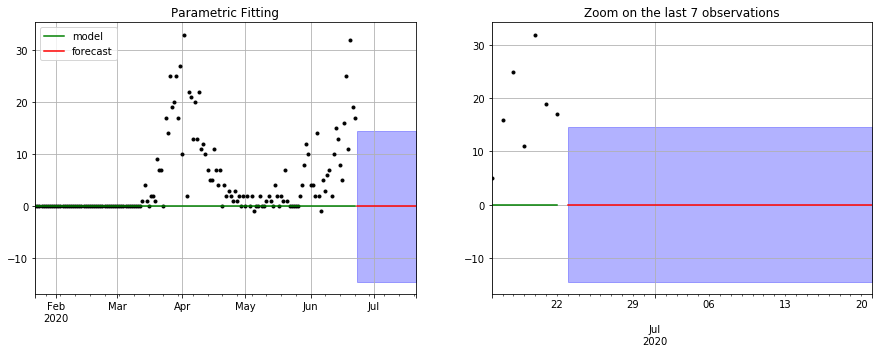

In [58]:
forecast_randomcity_both_cases(covid_df)

###Total Cases###
Making model for Iowa
forecast Iowa
--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


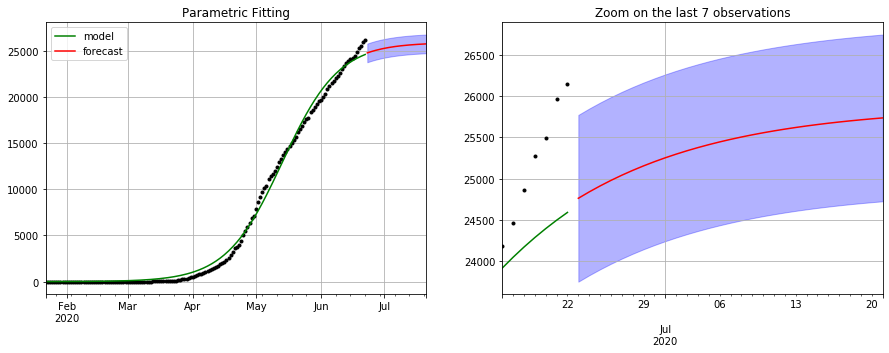

###New Cases###
Making model for Iowa
forecast Iowa
--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


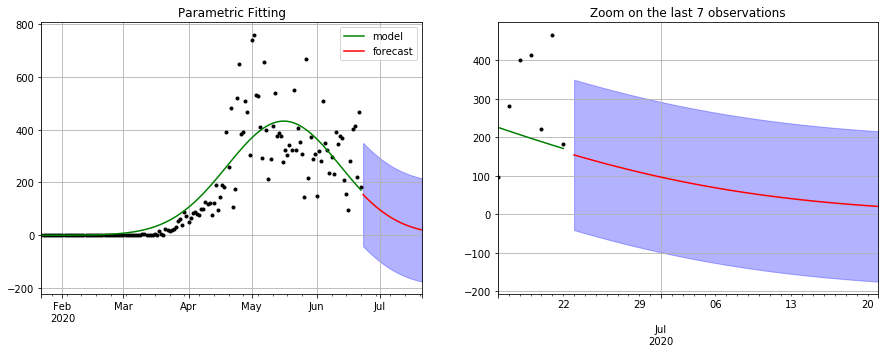

In [59]:
forecast_randomcity_both_cases(covid_df)

###Total Cases###
Making model for Wisconsin
forecast Wisconsin
--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


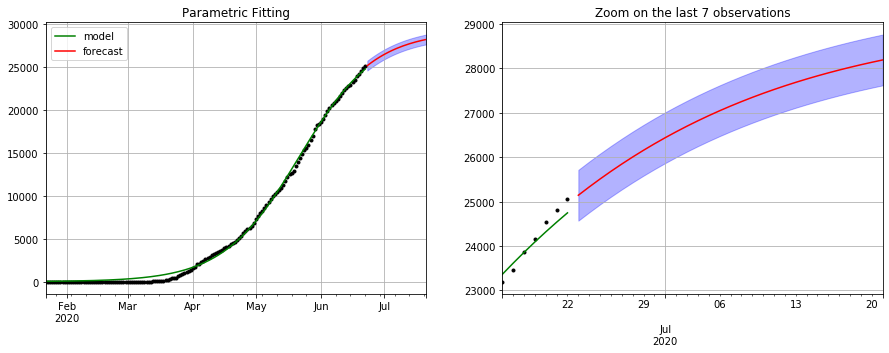

###New Cases###
Making model for Wisconsin
forecast Wisconsin
--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


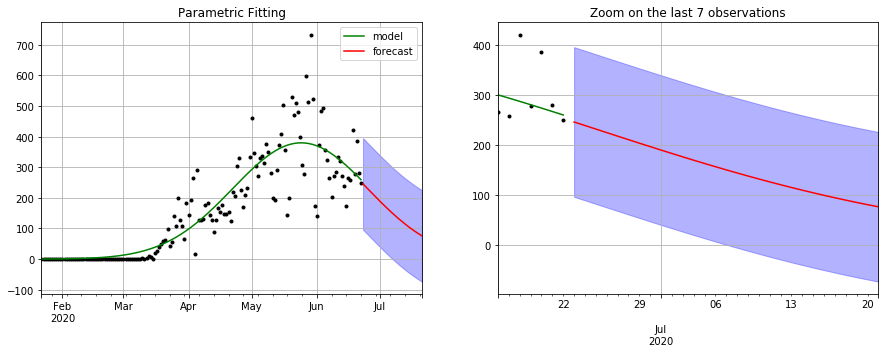

In [60]:
forecast_randomcity_both_cases(covid_df)

###Total Cases###
Making model for Montana
forecast Montana
--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


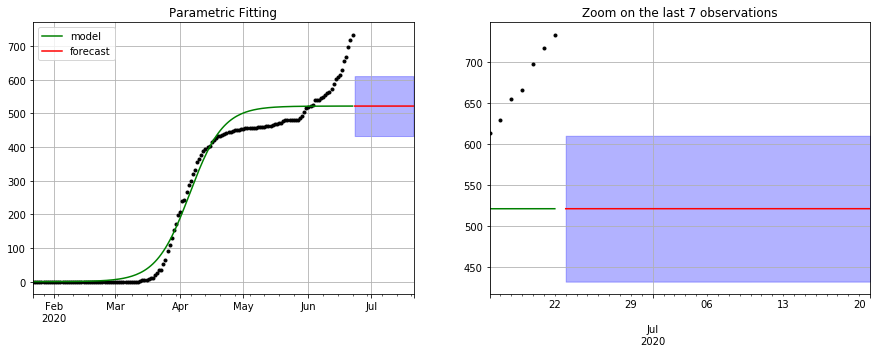

###New Cases###
Making model for Montana
forecast Montana
--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


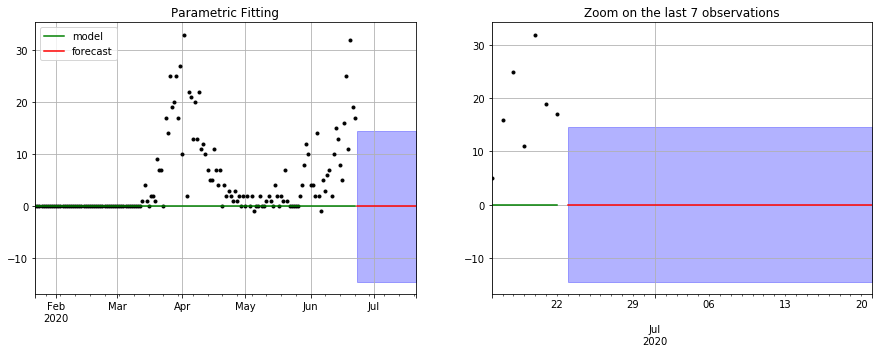

In [62]:
forecast_randomcity_both_cases(covid_df)

###Total Cases###
Making model for North Carolina
forecast North Carolina
--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


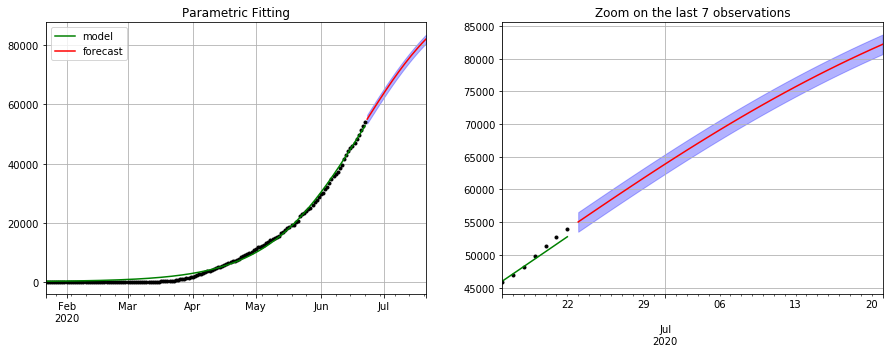

###New Cases###
Making model for North Carolina
forecast North Carolina
--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


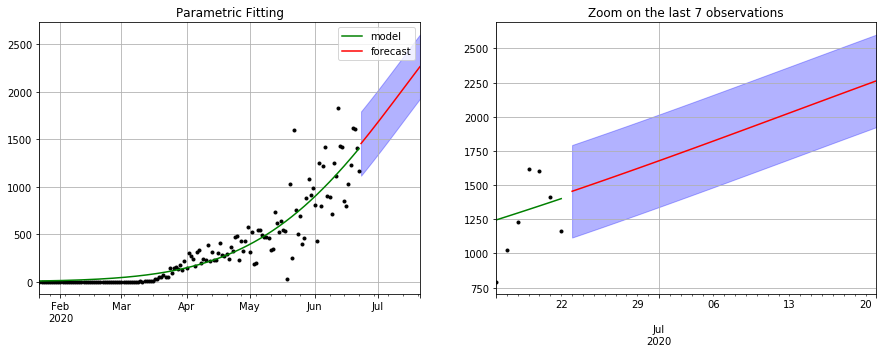

In [63]:
forecast_randomcity_both_cases(covid_df)

### Checking data for Stationarity

What is `Stationarity`?
For us to use any of the above menting TSFMs our time-series, We need to first Identfy if the given time-series is `Stationarity`

For a time-series to be Stationarity, the following do not change over time
1. mean(μ) 
2. standard deviation(σ) 
3. Autocorrelation structure (No seasonality)

for more info see [Stationarity](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc442.htm)

There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

* p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
* p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

source: [How to Check if Time Series Data is Stationary with Python](https://machinelearningmastery.com/time-series-data-stationary-python/)

Want to know more about [How to Check if Time Series Data is Stationary with Python](https://machinelearningmastery.com/time-series-data-stationary-python/)


> If we fit a stationary model to data, we assume our data are a realization of a stationary process. So our first step in an analysis should be to check whether there is any evidence of a trend or seasonal effects and, if there is, remove them.

— Page 122,  [Introductory Time Series with R](http://www.amazon.com/dp/0387886974?tag=inspiredalgor-20).

`The problem is that we can not remove any data for an the is defined as epi curve`

In [64]:
def getStationarity(df, States):
    #print(ts[0])
    df_return = pd.DataFrame() 
    arr_state = []
    arr_adf = []
    arr_p_value = []
    arr_usedlag = [] 
    arr_nobs = []
    arr_1 =[]
    arr_5 = []
    arr_10 = []
    icbest=[]
    res = []
    cit_stationary =[]
    
    threshold = 0.05
    print("### Testing Null Hypothesis ###")
    for aState in States:
        try:
            Cases=getCases(df, aState)
            #print(Cases[0])
            adfuller_results = sts.adfuller(Cases[0].total)
            #print(adfuller_results)
            arr_state.append(aState)
            arr_adf.append(round(adfuller_results[0],3))
            if round(adfuller_results[1],3)>threshold:
                res.append(0) #0 implies non-stationary
            else:
                res.append(1) #1 implies stationary
                cit_stationary.append(aState)
            arr_p_value.append(round(adfuller_results[1],3))
            arr_usedlag.append(round(adfuller_results[2],3))
            arr_nobs.append(round(adfuller_results[3],3))
            arr_1.append(round(adfuller_results[4]['1%'],3))
            arr_5.append(round(adfuller_results[4]['5%'],3))
            arr_10.append(round(adfuller_results[4]['10%'],3))
            icbest.append(round(adfuller_results[3],3))
            #print("\n\n")
        except:
            print("An occurred with city: ", aState)
    #print(arr_1)
    df_return['State'] = arr_state
    df_return['stationary'] = res
    df_return['adf'] = arr_adf
    df_return['p-value'] = arr_p_value
    df_return['usedlag'] = arr_usedlag
    df_return['nobs'] = arr_nobs
    df_return['significance_1'] = arr_1
    df_return['significance_5'] = arr_5
    df_return['significance_10'] = arr_10
    df_return['icbest'] = icbest
    
    print("Calculation Complete")
    print("adfuller results:")
    print(str(len(States)-len(cit_stationary)) + " p-value >  0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.")
    print(str(len(cit_stationary)) + " p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.")
    print("--------------------")
    print(str(len(States)) + " Total")
    
    #df_return.set_index('City')
    #return None
    return df_return, cit_stationary

In [65]:
stationarity_df = getStationarity(covid_df, state[0:])

### Testing Null Hypothesis ###
Calculation Complete
adfuller results:
56 p-value >  0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
2 p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
--------------------
58 Total


# For all of USA
benchmark model: http://modestya.securized.net/covid19prediction/

In [66]:
#Loading data into pandas
covid_df_usa = pd.read_csv(csv_file)

In [67]:
#Group by Country_Region=US, getting red of unnecessary columns
covid_df_usa = covid_df_usa.drop(['UID','iso2','iso3','code3','FIPS','Admin2','Province_State','Lat','Long_','Combined_Key'], axis=1).groupby("Country_Region").sum().T

In [68]:
covid_df_usa.head()

Country_Region,US
1/22/20,1
1/23/20,1
1/24/20,2
1/25/20,2
1/26/20,5


In [69]:
## convert index to datetime
covid_df_usa.index = pd.to_datetime(covid_df_usa.index, infer_datetime_format=True)

In [70]:
covid_df_usa.head()

Country_Region,US
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,5


In [71]:
covid_df_usa = pd.DataFrame(index=covid_df_usa.index, data=covid_df_usa['US'].values, columns=["total"])
covid_df_usa["new"] = covid_df_usa["total"] - covid_df_usa["total"].shift(1)
covid_df_usa["new"] = covid_df_usa["new"].fillna(method='bfill')

In [72]:
covid_df_usa.head()

,total,new
2020-01-22,1,0.0
2020-01-23,1,0.0
2020-01-24,2,1.0
2020-01-25,2,0.0
2020-01-26,5,3.0


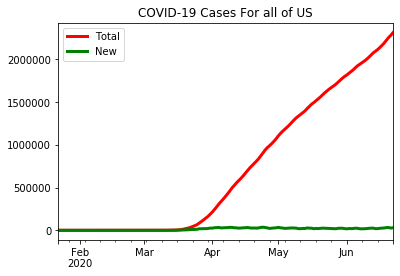

In [73]:
plt.title("COVID-19 Cases For all of US")
covid_df_usa.total.plot(label='Total', linewidth=3, color='red')
covid_df_usa.new.plot(label='New', linewidth=3, color='green')
plt.legend()
plt.show()

In [74]:
model = fit_curve(X=np.arange(len(covid_df_usa["total"])), y=covid_df_usa["total"].values, f=curve_logistic, p0=[np.max(covid_df_usa["total"]), 1, 1])
model

array([2.21167531e+06, 6.08466560e-02, 1.01843337e+02])

--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


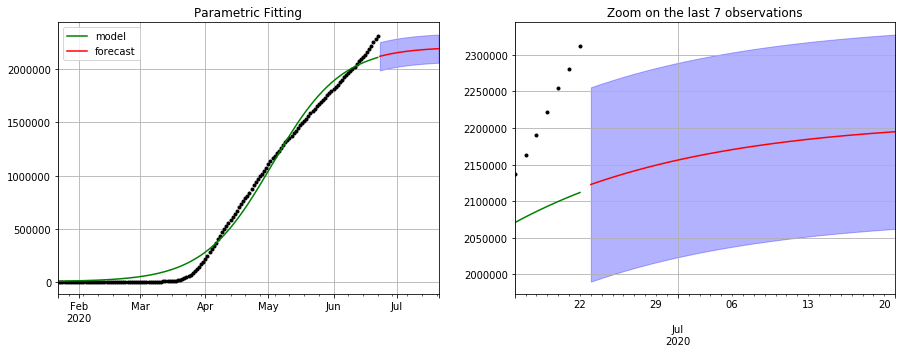

In [75]:
## Forecast
preds = forecast_curve(covid_df_usa["total"], curve_logistic, model, pred_ahead=30, end=None, freq="D", zoom=7, figsize=(15,5))

--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-06-24 00:00:00 | len: 2 ---


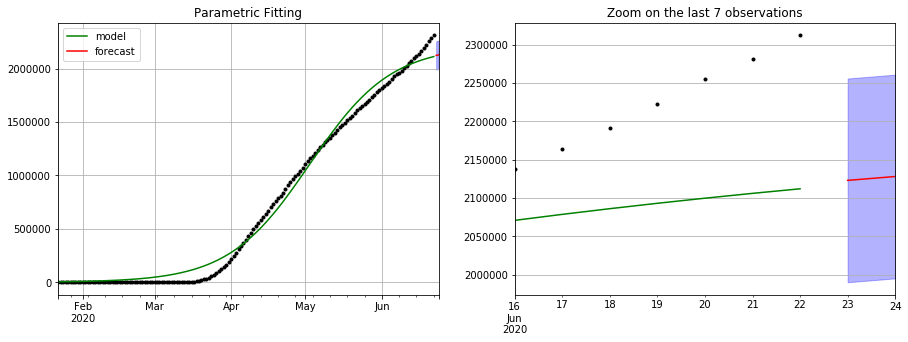

In [76]:
## Forecast
preds = forecast_curve(covid_df_usa["total"], curve_logistic, model, pred_ahead=3, end=None, freq="D", zoom=7, figsize=(15,5))

In [83]:
def forecast_aState_both_cases_withFunction(df, rState, f_total=curve_logistic, f_new=curve_gaussian):
    #rState = random.randint(0, len(state))   
    Cases=getCases(df, rState)[0]
    print("###Total Cases###")
    print('Making model for ' + rState)
    model = fit_curve(X=np.arange(len(Cases["total"])), y=Cases["total"].values, f=f_total, p0=[np.max(Cases["total"]), 1, 1])
    print('forecast ' + rState)
    preds = forecast_curve(Cases["total"], f_total, model, pred_ahead=30, end=None, freq="D", zoom=7, figsize=(15,5))
    
    print("###New Cases###")
    print('Making model for ' + rState)
    model = fit_curve(X=np.arange(len(Cases["new"])), y=Cases["new"].values, f=f_new, p0=[1, np.mean(Cases["new"]), np.std(Cases["new"])])
    print('forecast ' + rState)
    preds = forecast_curve(Cases["new"], f_new, model, pred_ahead=30, end=None, freq="D", zoom=7, figsize=(15,5))
    

###Total Cases###
Making model for North Dakota
forecast North Dakota
--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


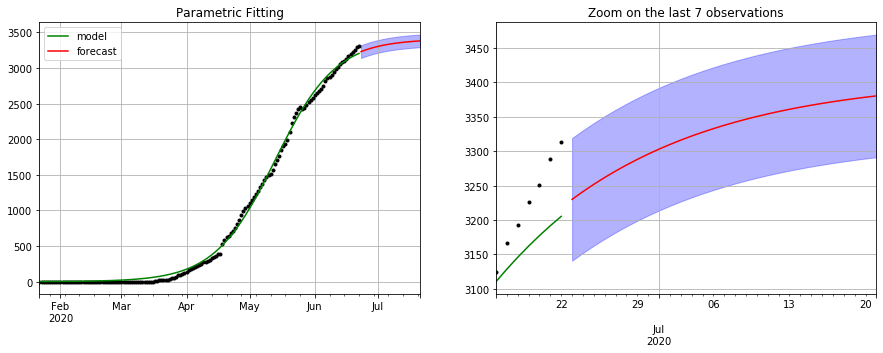

###New Cases###
Making model for North Dakota
forecast North Dakota
--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


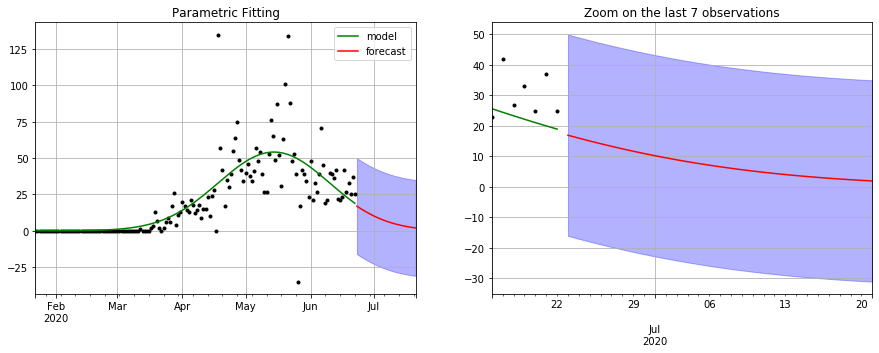

In [84]:
forecast_aState_both_cases_withFunction(covid_df, "North Dakota")

In [121]:
import math 
'''
Function to fit. In this case logistic function:
    f(x) = mx + b
'''
def curve_linear(X, c, k, m):
    y = m*X + k*c
    return y

'''
Function to fit. In this case logistic function:
    f(x) = log(a,X)
'''
def curve_log(X, c, k, m):
    y = X*math.log(c) + m
    return y

###Total Cases###
Making model for North Dakota
forecast North Dakota
--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


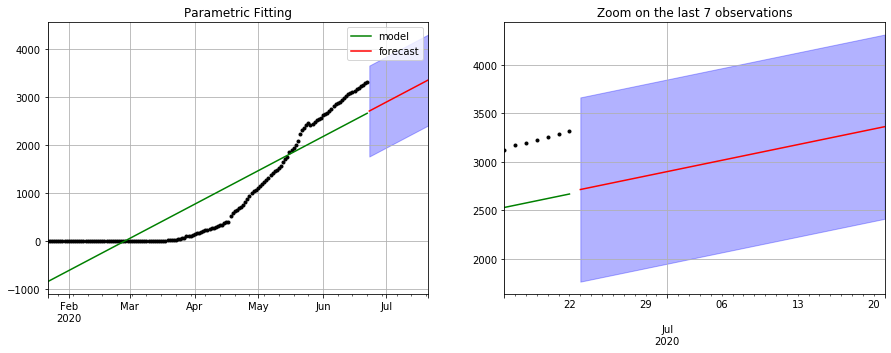

###New Cases###
Making model for North Dakota
forecast North Dakota
--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


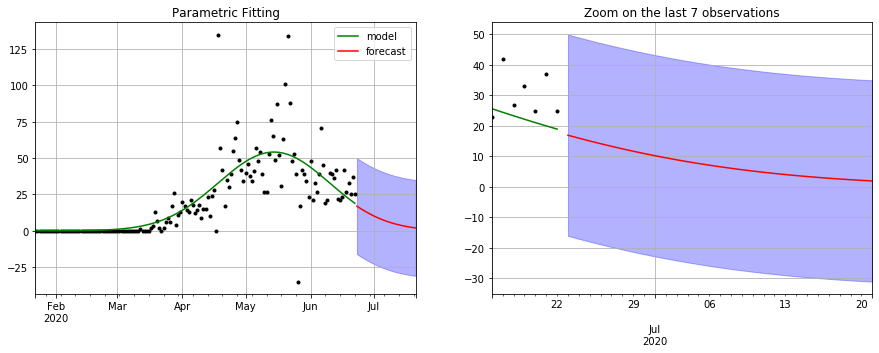

In [122]:
forecast_aState_both_cases_withFunction(covid_df, "North Dakota", curve_linear)

###Total Cases###
Making model for North Dakota
forecast North Dakota
--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


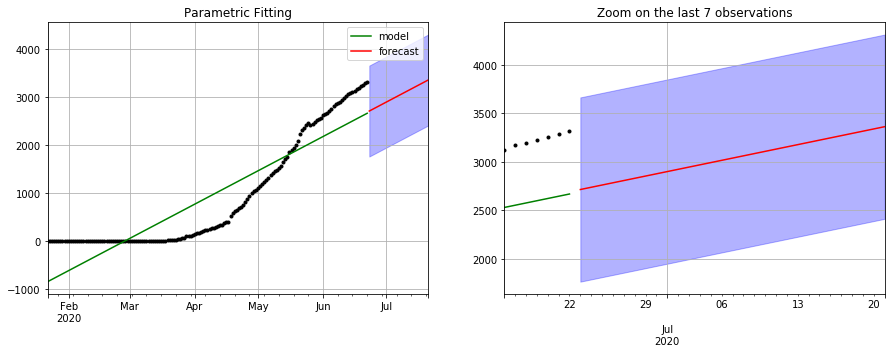

###New Cases###
Making model for North Dakota
forecast North Dakota
--- generating index date --> start: 2020-06-23 00:00:00 | end: 2020-07-21 00:00:00 | len: 29 ---


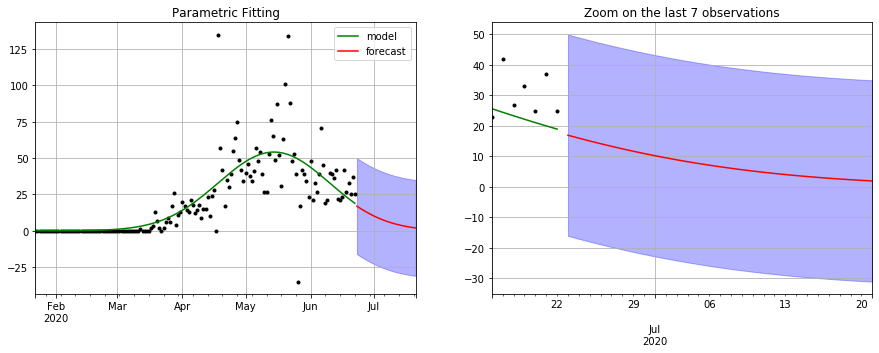

In [123]:
forecast_aState_both_cases_withFunction(covid_df, "North Dakota", curve_log)

In [111]:
math.log(2,5)

0.43067655807339306